# 1d spectral extraction using simple summation and optimum spectral extraction

***

**Author:** Tri L. Astraatmadja, tastraatmadja@stsci.edu
<br>
**Date:** September 9 2025

This note demonstrates a simple method to recover a calibrated 1d spectrum of a point source, by using simple summation along the cross-dispersion axis. 

We'll use one of the <i>Roman</i> supernova 2d spectral image simulated for this edition of the data challenge. The input spectrum used for simulation is a Type Ia Supernova generated using `sncosmo` (without the host-galaxy. Let's keep things simple for now), but you don't have to install the package as the required information have been written into files available in the Data Challenge repository.

We'll try to recover the original input 1d spectrum given the observed 2d spectrum.

Afterwards, we'll also demonstrate a technique called optimum spectral extraction <a href="https://ui.adsabs.harvard.edu/abs/1986PASP...98..609H/abstract">(Horne 1986)</a> to do the same task and see what are the advantages of this technique compared to a simple summation.

In [1]:
from astropy.io import fits
from astropy import modeling, units as u
from matplotlib import gridspec, pyplot as plt, ticker
import numpy as np
import pandas as pd
from scipy import constants as sciconstants, integrate, interpolate
import synphot as syn

## Golden ratio
GOLDEN_RATIO = sciconstants.golden_ratio

## Roman pixel scale
ROMAN_PIXEL_SCALE = 0.11 * u.arcsec / u.pix

## Some plotting settings
plt.rc('font', family='serif')
plt.rc('text', usetex=True) ## Comment this line if you don't have TeX installed
plt.rc('font', size=20)     ## Reduce this number if you don't like big text
plt.rc('xtick', direction='in', top=True, bottom=True)
plt.rc('ytick', direction='in', left=True, right=True)

## Loading the 2d spectral image

We'll assume that host-galaxy of the supernova has been perfectly removed (I know it might be asking a lot to suspend the reader's disbelief on this matter, but hopefully for the purpose of this demonstration readers can do this). We already have the file in our spectral library, let's read it.

In [2]:
filename = "../prism_spectra/sn/roman_simulated_SNe_spectra_intro.fits"

hduList = fits.open(filename)

## Look at what's inside
hduList.info()

Filename: ../prism_spectra/sn/roman_simulated_SNe_spectra_intro.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      22   ()      
  1  SCI           1 ImageHDU        35   (51, 259)   float64   
  2  ERR           1 ImageHDU        33   (51, 259)   float64   
  3  TRUE          1 ImageHDU        33   (51, 259)   float64   
  4  WAVEPIX       1 BinTableHDU     18   208R x 1C   [D]   


The command above will read the FITS file using `astropy` and generate an HDUList object. If we do `hduList.info()` command above, it'll show the HDUs. These are 5 observations of a supernova. Each observation contains the observed image (`SCI`), error image (`ERR`, standard deviation of each measured pixel), as well as the noise-free image (`TRUE`). In addition to these images, the wavelength will also be given (`WAVEPIX`), as well as the sky-background image (`BG`) used to generate the sky noise.

Let's plot the 2d spectra images, both the noise-free and noisy data. Note that <i>Roman</i> prism disperse light along the $y$ axis in detector space. For illustration purpose, however, we'll transpose the image such that it'll disperse horizontally.

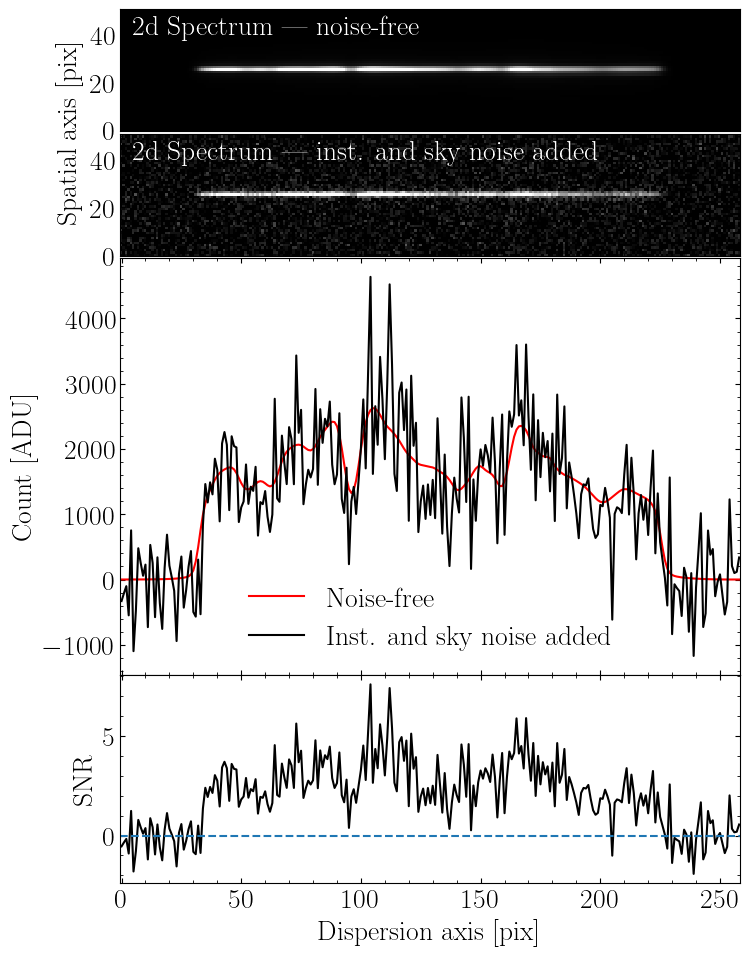

In [3]:
## Plot the 2d spectra images, the noise-free and the noisy data
nRows = 4
nCols = 1

xSize = 8
ySize = 2.3 * xSize/GOLDEN_RATIO

wspace = 0.00
hspace = 0.00

dX, dMX = 50, 10
dY, dMY = 20, 5

CI   = 99.0
P_HI = 0.5*(100.0 + CI)

fig, axes = plt.subplots(nRows, nCols, sharex=True, sharey=False, height_ratios=[0.3, 0.3, 1, 0.5], figsize=(xSize, ySize))

for k in range(2):
    ax = axes[k]

    ## Grab the noise-free image from the HDUList. Also sum the fluxes along the cross-dispersion axis to get a hang of what 
    ## the 1d spectrum would look like
    if (k == 0):
        title = '2d Spectrum --- noise-free'
        image = hduList['TRUE', 1].data.T
        
        spec1d_noiseFree = image.sum(0)

    ## Now we grab and display the noisy image.
    if (k == 1):
        title = '2d Spectrum --- inst. and sky noise added'
        image = hduList['SCI', 1].data.T
        
        stdDevImage = hduList['ERR', 1].data.T

        spec1d_noisy = image.sum(0)
        stdDev1d     = np.sqrt((stdDevImage ** 2).sum(0))

        ## Signal to noise ratio: Measured count over the measured uncertainties (std. dev.)
        snr1d = spec1d_noisy / stdDev1d
        
        ax.set_xlabel(r'Dispersion axis [pix]')
        
    vmin, vmax = 0.0, np.percentile(image, P_HI)

    ax.imshow(image, aspect='equal', cmap='gray', origin='lower', vmin=vmin, vmax=vmax, interpolation='nearest')
        
    ax.text(0.02, 0.95, title, color='white', ha='left', va='top', transform=ax.transAxes)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(dX))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(dMX))

    ax.yaxis.set_major_locator(ticker.MultipleLocator(dY))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

    ## ax.set_ylabel(r'Spatial axis [pix]');

dY, dMY = 1000, 200

axes[2].plot(spec1d_noiseFree, color='r', label='Noise-free')
axes[2].plot(spec1d_noisy, color='k', label='Inst. and sky noise added')

axes[2].legend(frameon=False, loc='best')

axes[2].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[2].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

axes[2].set_ylabel(r'Count [ADU]')

axes[3].plot(snr1d, color='k')

axes[3].axhline(linestyle='--')

axes[3].set_xlabel(r'Dispersion axis [pix]')

dY, dMY = 5, 1
## axes[3].set_ylim(-3, 7.5)
axes[3].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[3].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

axes[3].set_ylabel(r'SNR')

plt.subplots_adjust(wspace=wspace, hspace=hspace)

## Make common label for the first two plots
axes[0].text(-0.06, 0.0, r'Spatial axis [pix]', rotation='vertical', ha='right', va='center', transform=axes[0].transAxes);

There's quite a lot of noise when we sum everything along the dispersion axis! This is the point of a simple summation, is to find a good balance between aperture width and signal-to-noise.

## 1d Spectral extraction by simple summation along the cross-dispersion axis

Below we're now going to extract 1d spectrum from the noisy image using several aperture width: 
-  $w = 1$ (just the central row),
-  $w = 3$ (one row above and below the central row),
-  $w = 5$ (two rows above and below the central row), and
-  $w=11$ (five rows above and below the central row).

In [4]:
## Declare the half-width, which are 0, 1, and 5
dKs    = np.array([0, 1, 2, 5], dtype=int)
colors = ['#bae4bc', '#7bccc4','#43a2ca','#0868ac'] ## Color code for each half-width

25 233


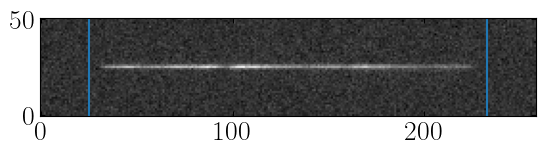

In [5]:
## Grab the noisy image from the HDUList, and transpose so that the dispersion axis is along the horizontal axis
noisySpec     = hduList['SCI'].data.T
stdDevImage   = hduList['ERR'].data.T
noiseFreeSpec = hduList['TRUE'].data.T

## Get shape of the image
nK, nM = noisySpec.shape

## Find the zero-point of the extraction. The vertical zero-point is the central row, containing the object 
## which spectrum we want to extract. The horizontal zero-point is location of the reference wavelength, which
## is written in the header and (hopefully) is based on some calibration efforts
y_c, x_c = (nK // 2), int(hduList['WAVEPIX', 1].header['W_REFPIX'])

## This is the range of extraction along the dispersion axis, which is as long as the 
## wavelength array
xxMin, xxMax = x_c, x_c + hduList['WAVEPIX', 1].data['wavelength'].size

print(xxMin, xxMax)

## quick plot of the data
plt.imshow(noisySpec, cmap='grey', origin='lower')

plt.axvline(xxMin)
plt.axvline(xxMax)

In [6]:
## We'll declare an empty array to contain the extracted 1d spectra
spec1d_uncalib         = np.zeros((len(dKs), hduList['WAVEPIX', 1].data['wavelength'].size))
spec1d_uncalib_stdDev  = np.zeros_like(spec1d_uncalib)

## We'll now cycle over the half-widths and extract 1d spectra based on a given half-width
for k, dK in enumerate(dKs):
    ## Define the cross
    yyMin = max(0,  y_c - dK)
    yyMax = min(nK, y_c + dK+1)

    print(dK, y_c, yyMin, yyMax, end=' ')

    ## This is the main event, where we grab the relevant area in the data and sum it along the cross-dispersion axis.
    ## Note that previously we transpose the data so that the cross-dispersion axis is along the vertical.
    ## We'll save this arrays of 1d spectra because we'll use them later
    spec1d_uncalib[k]        = noisySpec[yyMin:yyMax, xxMin:xxMax].sum(0)
    spec1d_uncalib_stdDev[k] = np.sqrt((stdDevImage[yyMin:yyMax, xxMin:xxMax] ** 2).sum(0))

    snr = np.nanmedian(spec1d_uncalib[k] / spec1d_uncalib_stdDev[k])
    
    print("AVG. SNR:", snr)

## For comparisons between 1d extracted spectra, we'll calculate the one-dimensional noise-free 1d spectrum by simply 
## summing everything along the cross-dispersion axis.
spec1d_uncalib_noiseFree = noiseFreeSpec.sum(0)

0 25 25 26 AVG. SNR: 8.337281541292533
1 25 24 27 AVG. SNR: 8.581698153449164
2 25 23 28 AVG. SNR: 7.44867372340573
5 25 20 31 AVG. SNR: 5.412572094188101


0 25 25 26 MEDIAN FLUX LOSS =  -0.5459205475569302 MEDIAN SNR =  8.337281541292533
1 25 24 27 MEDIAN FLUX LOSS =  -0.1993935200993167 MEDIAN SNR =  8.581698153449164
2 25 23 28 MEDIAN FLUX LOSS =  -0.12940543200365398 MEDIAN SNR =  7.44867372340573
5 25 20 31 MEDIAN FLUX LOSS =  -0.06023575292563915 MEDIAN SNR =  5.412572094188101


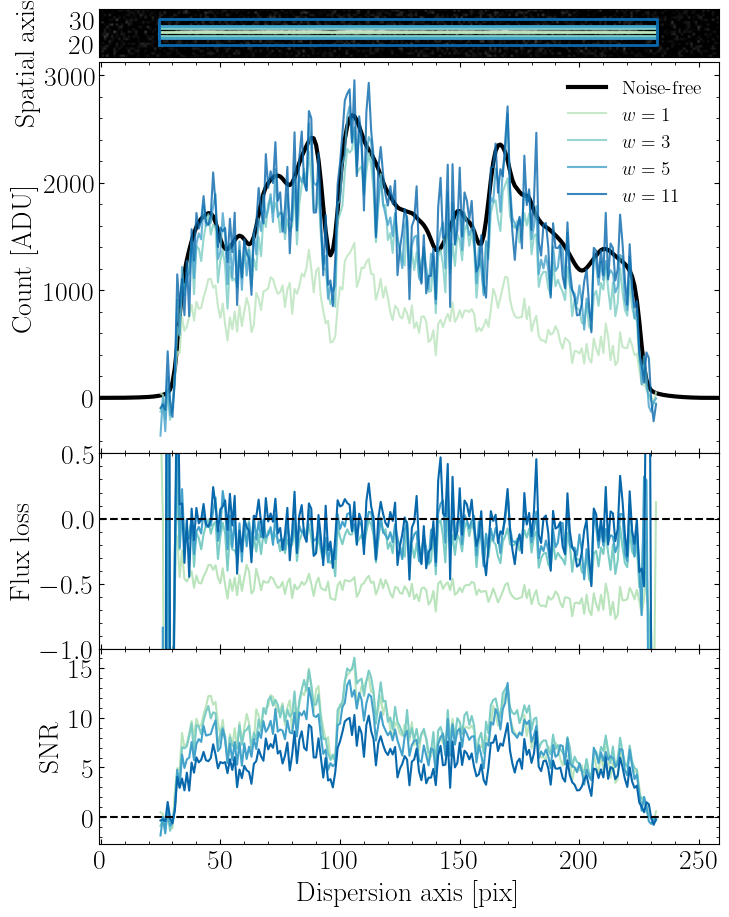

In [7]:
## Some plotting declarations
nRows = 4
nCols = 1

xSize = 8
ySize = 2.0 * xSize / GOLDEN_RATIO

CI  = 99.5
pHi = 0.5 * (100.0 + CI)

dCut = 10

opacity = 0.8
                
fig, axes = plt.subplots(figsize=(xSize, ySize), ncols=nCols, nrows=nRows, sharex=True, sharey=False, height_ratios=[0.15, 1.0, 0.5, 0.5])

plt.subplots_adjust(hspace=0.0, top=0.95, bottom=0.1)

dX, dMX = 50, 10
dY, dMY = 10, 2

## This is the pixel coordinate along the dispersion axis, but we only use the parts
## where there are non-zero fluxes from the source, and here it is based on the wavelength array
pixCoords = np.arange(nM, dtype=int)[xxMin:xxMax]
    
vmin = 0.0
vmax = np.nanpercentile(noisySpec, pHi)

axes[0].imshow(noisySpec, origin='lower', cmap='grey', aspect='equal', vmin=vmin, vmax=vmax)

axes[0].set_ylim(y_c - dCut - 0.5, y_c + dCut - 0.5)

axes[1].plot(spec1d_uncalib_noiseFree, 'k-', label='Noise-free', linewidth=3)

for k, (dK, color) in enumerate(zip(dKs, colors)):
    label = '$w = '+'{0:d}'.format(2 * dK + 1)+'$'
    
    yyMin = max(0,  y_c - dK)
    yyMax = min(nK, y_c + dK+1)

    print(dK, y_c, yyMin, yyMax, end=' ')

    ## Draw the vertices of the box for the area where spectral extraction is going to be performed
    vertices = np.array([[xxMin-0.5, y_c], [xxMax-0.5, y_c]])

    if (dK > 0):
        vertices = np.array([[xxMin-0.5, yyMin-0.5],
                             [xxMin-0.5, yyMax-0.5],
                             [xxMax-0.5, yyMax-0.5],
                             [xxMax-0.5, yyMin-0.5]])
        vertices = np.vstack([vertices, vertices[0]])

    axes[0].plot(vertices[:,0], vertices[:,1], '-', color=color, linewidth=2)

    axes[1].plot(pixCoords, spec1d_uncalib[k], '-', color=color, label=label, alpha=opacity)

    ## We do a simple flux loss calculation, which is basically a fractional residual between the obtained 1d spectrum
    ## and the true, noiseless, 1d spectrum.
    fluxLoss = (spec1d_uncalib[k] - spec1d_uncalib_noiseFree[xxMin:xxMax]) / spec1d_uncalib_noiseFree[xxMin:xxMax]

    ## We calculate the SNR of the extraction
    snr1d = spec1d_uncalib[k] / spec1d_uncalib_stdDev[k]

    print("MEDIAN FLUX LOSS = ", np.nanmedian(fluxLoss), "MEDIAN SNR = ", np.nanmedian(snr1d))

    axes[2].plot(pixCoords, fluxLoss, '-', color=color, label=label)

    axes[3].plot(pixCoords, snr1d, '-', color=color, label=label)

axes[0].xaxis.set_major_locator(ticker.MultipleLocator(dX))
axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(dMX))
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[0].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

axes[0].set_ylabel(r'Spatial axis [pix]', labelpad=20)

axes[1].yaxis.set_major_locator(ticker.MultipleLocator(1000))
axes[1].yaxis.set_minor_locator(ticker.MultipleLocator(200))

## axes[1].set_ylim(-321.37194664311335, 2900.0)

axes[1].set_ylabel(r'Count [ADU]')
axes[1].legend(frameon=False, loc='upper right', fontsize='x-small')

axes[2].axhline(linestyle='--', color='k')

axes[2].set_ylim(-1.0, +0.5)

axes[2].yaxis.set_major_locator(ticker.MultipleLocator(0.5))
axes[2].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

axes[2].set_ylabel(r'Flux loss')

## axes[3].set_ylim(-2.0, 18.0)

axes[3].set_xlabel(r'Dispersion axis [pix]')
axes[3].set_ylabel(r'SNR')

axes[3].axhline(linestyle='--', color='k')

dY, dMY = 5.0, 1.0

axes[3].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[3].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

As we can see, there's plenty of flux loss when we take only a single line, also when we sum only along 3 rows. We can also see that due to the varying width of the psf with wavelength, the flux loss is worse at redder wavelengths.

Looking at the SNR plot, however, we can see that as we widen the aperture, we admit more noise, resulting in lower SNR.

This is the <a href="https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff">bias-variance tradeoff</a>, a typical problem in statistics and (especially) machine-learning, that arise when we tune the parameters of our model.

Thus in 1d spectra extraction using simple, unweighted, summation, the appropriate width is a balance between flux-loss (which represent the bias) and noise.

## Getting calibrated spectra

Let's create calibrated 1d spectra from these uncalibrated 1d spectra. Again we're going to keep it simple. In a given pixel $i$, the calibrated flux $f(\lambda_i)$ is
\begin{equation}
    f(\lambda_i) = \frac{I_i}{t_{\rm exp}A_{\rm eff}(\lambda_i)\left.\frac{d\lambda}{d\kappa_i}\right|_{\lambda_i}},
\end{equation}
where $I_i$ is the measured count at pixel $i$, $A_{\rm eff}(\lambda_i)$ is the telescope effective area at wavelength $\lambda_i$ ($i$-th pixel corresponds to wavelength), and $d\lambda/d\kappa_i$ is the spectral sampling at wavelength $\lambda_i$.

First let's grab the wavelength pixel array, i.e. the wavelength for each pixel along the trace of the 2d spectral image. The mapping between pixel coordinates along the trace of a 2d spectral image and their corresponding wavelengths should be inferred from calibration efforts. We're going to gloss that over and assume they have been obtained with sufficient accuracy. In this demonstration the simulated data has already gives mapping and is in the header.

In [8]:
wavePix = hduList['WAVEPIX', 1].data['wavelength'] * u.Unit(hduList['WAVEPIX', 1].header['TUNIT1'])

wavePix

<Quantity [ 7363.46366108,  7382.85024743,  7402.23683379,  7421.62342015,
            7441.0100065 ,  7460.39659286,  7479.78317922,  7499.16976557,
            7518.55635193,  7537.94293829,  7557.32952464,  7577.26881723,
            7598.2508339 ,  7619.23285056,  7640.21486723,  7661.19688389,
            7682.17890056,  7703.16091723,  7724.14293389,  7745.12495056,
            7766.58844577,  7789.22470268,  7811.86095958,  7834.49721648,
            7857.13347338,  7879.76973028,  7902.40598719,  7925.04224409,
            7947.67850099,  7971.83537361,  7996.16601683,  8020.49666006,
            8044.82730328,  8069.15794651,  8093.48858973,  8117.81923296,
            8142.30424368,  8168.38189939,  8194.4595551 ,  8220.53721081,
            8246.61486652,  8272.69252223,  8298.77017794,  8324.84783365,
            8352.36695138,  8380.24097847,  8408.11500556,  8435.98903265,
            8463.86305975,  8491.73708684,  8519.61111393,  8549.30223425,
            8579.01906454

Now, for this wavelength array we should get the corresponding effective area and the spectral sampling. We can do that using <a href="https://gitlab.com/astraatmadja/Ilia">the simulator `Ilia`</a> written by yours truly, but we're not going to do that here (because some installation and downloading some files are required and we want to keep it simple) and instead we'll load those required data from a `csv` file in this data challenge repository:

In [9]:
df_roman = pd.read_csv('Roman_prism_data.csv')

df_roman

,wavelength,effArea,sampling
0,700.0,0.0,15.24150
1,701.0,0.0,15.32835
2,702.0,0.0,15.41520
3,703.0,0.0,15.50205
4,704.0,0.0,15.58890
...,...,...,...
1196,1896.0,0.0,92.93190
1197,1897.0,0.0,92.93105
1198,1898.0,0.0,92.93020
1199,1899.0,0.0,92.92935


This *Roman* prism data is in quite a fine wavelength grid. We're going to interpolate this data grid to the wavelength pixel array

In [10]:
wave_grid     = df_roman['wavelength'].values * u.nm
effArea_grid  = df_roman['effArea'].values * u.cm ** 2
sampling_grid = df_roman['sampling'].values * u.angstrom / u.pix

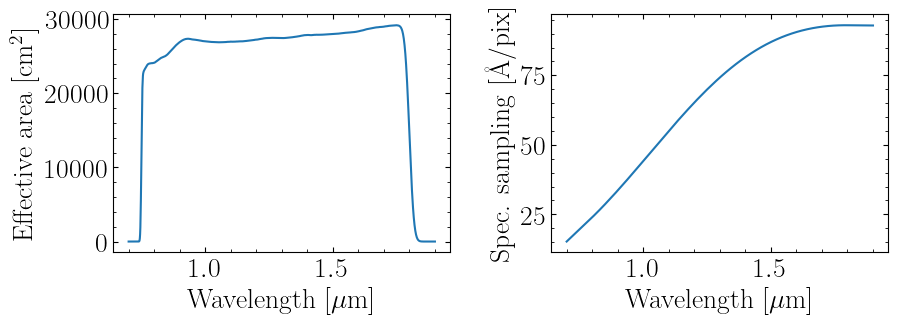

In [11]:
## Plot the effective area and dispersion to get a sense of what they look like
nCols = 2
nRows = 1

xSize = 10
ySize = nRows * xSize / nCols / GOLDEN_RATIO

fig, axes = plt.subplots(figsize=(xSize, ySize), ncols=nCols, nrows=nRows, sharex=True, sharey=False)

axes[0].plot(wave_grid.to(u.micron), effArea_grid)

axes[0].set_ylabel(r'Effective area [cm$^2$]');

axes[1].plot(wave_grid.to(u.micron), sampling_grid)

for i in range(nCols):
    axes[i].set_xlabel(r'Wavelength [$\mu$m]');

    axes[i].yaxis.set_major_locator(ticker.AutoLocator())
    axes[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
axes[1].set_ylabel(r'Spec. sampling [\AA/pix]');

axes[0].xaxis.set_major_locator(ticker.AutoLocator())
axes[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.subplots_adjust(wspace=0.3)

In [12]:
## Interpolating function for the effective area and spectral sampling
## We're going to use the wavelength in angstrom because that is the unit of WAVEPIX
f_effArea  = interpolate.interp1d(wave_grid.to(u.angstrom), effArea_grid, kind='quadratic', fill_value='extrapolate')
f_specSamp = interpolate.interp1d(wave_grid.to(u.angstrom), sampling_grid, kind='quadratic', fill_value='extrapolate')

## Now we interpolate the effective area and spectral sampling at the pixel wavelength array
effArea  = f_effArea(wavePix.value) * u.cm ** 2
specSamp = f_specSamp(wavePix.value) * u.angstrom / u.pix

A disclaimer to the readers is that these values are pre-launch and pre-TVAC values. The real values will vary not only for each WFI detector but also potentially for different position on each detector. See <a href="https://www.spiedigitallibrary.org/journals/Journal-of-Astronomical-Telescopes-Instruments-and-Systems/volume-11/issue-02/025001/Compact-prism-assembly-for-slit-less-spectroscopy-capability-in-Roman/10.1117/1.JATIS.11.2.025001.full">Eegholm et al. (2025)</a> for some examples.

Before we go on plotting the calibrated 1d spectra, let's generate the true supernova spectrum. The information to generate it is written in the primary header of the file.

In [13]:
hduList[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
VERSION = '3.28.4  '           / Version of the code                            
DATE    = '2025-09-08'         / date this file was written (yyyy-mm-dd)        
OVERSAMP=                    5 / input scene oversample factor                  
N_P     =                  255 / input scene oversampled spatial size in vertica
N_Q     =                  255 / input scene oversampled spatial size in horizon
N_OBS   =                    1 / number of observations                         
TELESCOP= 'Roman   '           / telescope used in this simulation              
INSTRUME= 'WFI     '           / identifier for instrument used in this simulati
EXPTIME =               3600

We can see in the header supernova is generated using `sncosmo` using the <a href="https://ui.adsabs.harvard.edu/abs/2007ApJ...663.1187H/abstract">Hsiao 2007</a> template, and at a relatively "nearby" supernova at redshift $z=0.5$. Also, it's not written in the header but the time of the supernova is at maximum brightness of the supernova.

We can use `sncosmo` to generate the true flux to compare this with the obtained calibrated 1d spectrum. But again we're going to keep this simple and not going to install `sncosmo`. The true flux of the supernova is already written in a csv file in this repository:

In [14]:
df_sn = pd.read_csv('supernova_true_flux.csv')

df_sn

,wavelength,flux_photlam
0,7363.463661,6.862591e-07
1,7382.850247,6.923931e-07
2,7402.236834,6.938897e-07
3,7421.623420,6.938475e-07
4,7441.010007,6.944065e-07
...,...,...
203,18258.637099,1.210660e-07
204,18351.624676,1.218268e-07
205,18444.604515,1.230178e-07
206,18537.575962,1.244355e-07


In [15]:
## Again, grab the flux and assign units
sn_true1dSpec = df_sn['flux_photlam'].values * syn.units.PHOTLAM

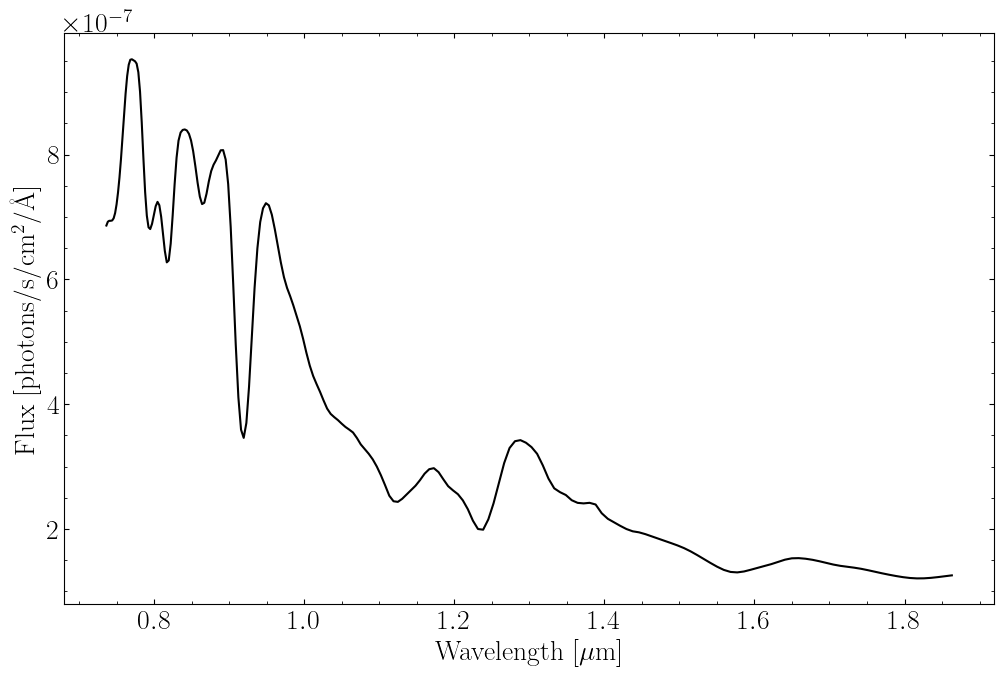

In [16]:
## Plot the spectrum, see if everything's alright
xSize = 12
ySize = xSize / GOLDEN_RATIO

opacity = 0.2

fig = plt.figure(figsize=(xSize, ySize))

ax = fig.add_subplot(111)

ax.plot(wavePix.to(u.micron), sn_true1dSpec, 'k-')

ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel(r'Flux [photons/s/cm$^2$/\AA]');

ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

ax.yaxis.set_major_locator(ticker.AutoLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

In [17]:
## Also, from the header, grab the exposure time of the observation
exposureTimeSp = hduList['SCI', 1].header['EXPTIME'] * u.s 

<Figure size 800x988.854 with 0 Axes>

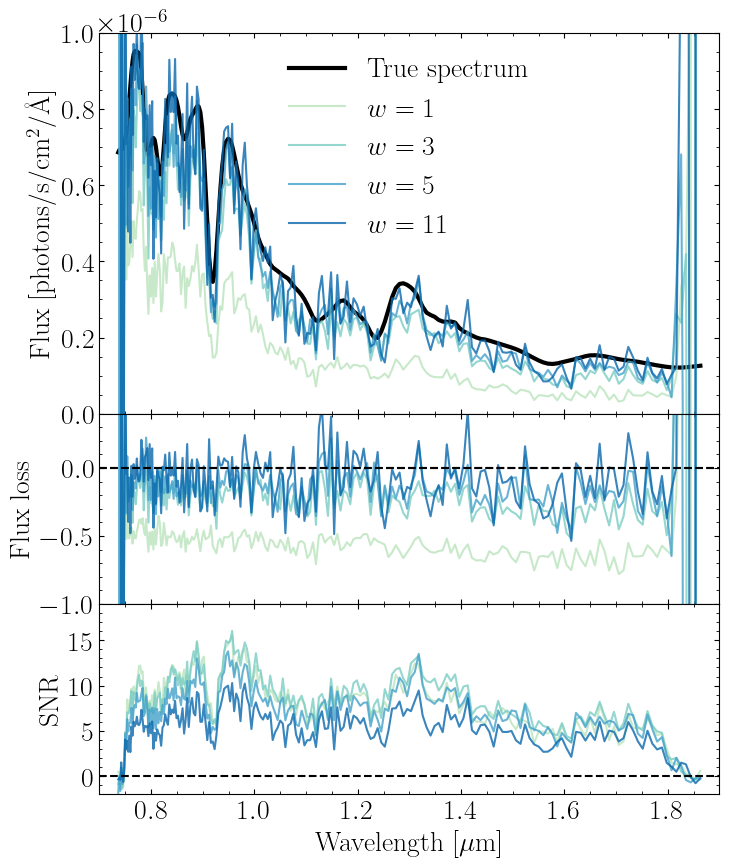

In [18]:
nRows = 3
nCols = 1

xSize = 8
ySize = 2 * xSize / GOLDEN_RATIO

xMin, xMax = 0.7000, 1.9000
dX, dMX = 0.2000, 0.0500

yMin, yMax = 0.0, 1.e-6

opacity = 0.8

fig = plt.figure(figsize=(xSize, ySize))

fig, axes = plt.subplots(nRows, nCols, sharex=True, sharey=False, figsize=(xSize, ySize), height_ratios=[1.0, 0.5, 0.5])

plt.subplots_adjust(hspace=0.0)

## This is the true flux of the supernova that we have showed earlier, plotted here for comparison
axes[0].plot(wavePix.to(u.micron), sn_true1dSpec, 'k-', label='True spectrum', linewidth=3)

axes[1].axhline(color='k', linestyle='--')

for k, (dK, color) in enumerate(zip(dKs, colors)):
    label = '$w = '+'{0:d}'.format(2 * dK + 1)+'$'
    
    spec1dNoisy  = spec1d_uncalib[k] * u.adu / u.pix
    spec1dStdDev = spec1d_uncalib_stdDev[k] * u.adu / u.pix

    ## Here the spectrum is divided by the spectral sampling, effective area, and the exposure time
    spec1d_cal_noisy = (spec1dNoisy / exposureTimeSp / effArea / specSamp) / (1.0 * u.adu / u.ph)
    spec1d_cal_std   = (spec1dStdDev /  exposureTimeSp / effArea / specSamp) / (1.0 * u.adu / u.ph)

    axes[0].plot(wavePix.to(u.micron), spec1d_cal_noisy, '-', color=color, label=label, alpha=opacity)

    fluxLoss = (spec1d_cal_noisy - sn_true1dSpec) / sn_true1dSpec

    axes[1].plot(wavePix.to(u.micron), fluxLoss, '-', color=color, label=label, alpha=opacity)

    snr_cal = spec1d_cal_noisy / spec1d_cal_std

    axes[2].plot(wavePix.to(u.micron), snr_cal, '-', color=color, label=label, alpha=opacity)
    
axes[0].set_xlim(xMin, xMax)
axes[0].set_ylim(0.0, yMax)
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(dX))
axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(dMX))
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(2.0e-7))
axes[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.5e-7))

axes[0].legend(frameon=False)

axes[0].set_ylabel(r'Flux [photons/s/cm$^2$/\AA]')

dY, dMY = 0.5, 0.1

axes[1].axhline(linestyle='--', color='k')

axes[1].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[1].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

axes[1].set_ylim(-1.0, +0.4)

axes[1].set_ylabel(r'Flux loss');

axes[2].axhline(linestyle='--', color='k')

axes[2].set_xlabel(r'Wavelength [$\mu$m]')

dY, dMY = 5, 1

axes[2].set_ylim(-2.0, +19.0)
axes[2].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[2].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

axes[2].set_ylabel(r'SNR');

## outFilename = "{0:s}/plot_1dSpectralExtraction_simpleSummation_calibrated.pdf".format(OUTDIR)
## fig.savefig(outFilename, bbox_inches='tight')

Again we can see here that due to the PSF convolution, the flux loss is more severe at redder wavelengths. We can increase the aperture width but this will increase noise and reduce the signal-to-noise ratio, as previously discussed.

Let's see if we can mitigate this by using optimum spectral extraction.


## Optimum spectral extraction (Horne 1986)

How can we do better? In simple summation to extract a 1d spectrum from a 2d spectal image, we give equal weights to all the cross-dispersion pixels that we sum, even though most of the light is in a central row along the dispersion axis. If we can just weight the pixels accordingly, where the brightest pixel along the cross-dispersion axis is weighted more than those from the central row, we might be able to do better...
<br>
Let's see how we can assign the proper weights to all these pixels...

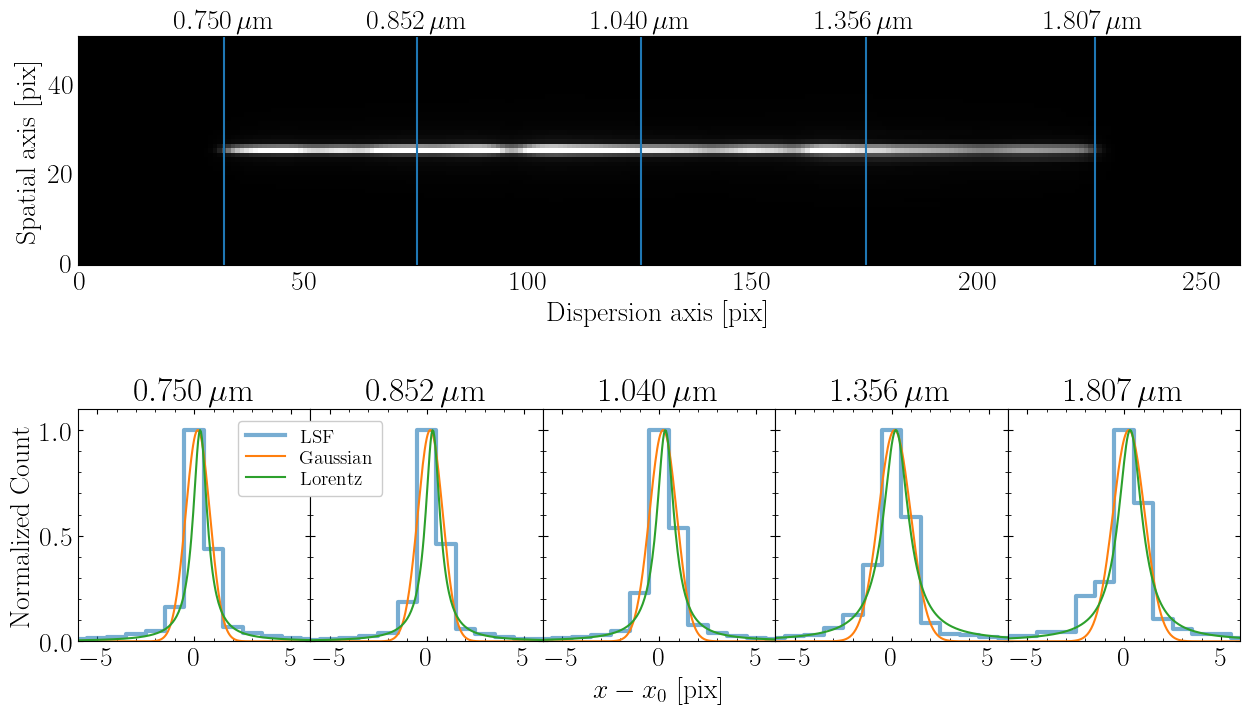

In [19]:
xSize = 15
ySize = 0.9 * xSize / GOLDEN_RATIO

fig = plt.figure(figsize=(xSize, ySize))

gs = gridspec.GridSpec(2, 5, figure=fig, wspace=0.0, hspace=0.40, height_ratios=[1.0, 1.0])

ax0 = fig.add_subplot(gs[0,:])

## Get the data again and transpose so that the dispersion axis is along the horizontal axis
noiseFreeSpec = hduList['True'].data.T

## Get the shape of the (transposed) postaged stamp
nK, nM = noiseFreeSpec.shape

## Get the central row and the starting column of the wavelength grid 
y_c, x_c = (nK // 2), int(hduList['WAVEPIX', 1].header['W_REFPIX'])

## Just to make things easy, create a grid of pixel coordinates
xx, yy = np.meshgrid(np.arange(nM), np.arange(nK))

## Select an arbitrary wavelength slice where we want to display the LSF
waveSlices = np.array([7, 50, 100, 150, wavePix.size-7], dtype=int)

vmin = 0
vmax = np.percentile(noiseFreeSpec, 99.5)

## Display the noise-free image
ax0.imshow(noiseFreeSpec, aspect='equal', cmap='gray', origin='lower', vmin=vmin, vmax=vmax, interpolation='nearest')

ax0.set_xlabel(r'Dispersion axis [pix]')
ax0.set_ylabel(r'Spatial axis [pix]')

dX, dMX = 50, 10
dY, dMY = 20, 5

ax0.xaxis.set_major_locator(ticker.MultipleLocator(dX))
ax0.xaxis.set_minor_locator(ticker.MultipleLocator(dMX))

ax0.yaxis.set_major_locator(ticker.MultipleLocator(dY))
ax0.yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

xRange = 5.99
yMax   = 1.1

dX, dMX = 5.0, 1.0
dY, dMY = 0.5, 0.1

## Declare the fitter to model the LSF and two models: Gaussian and Lorentz function
fitter = modeling.fitting.LevMarLSQFitter()
models = [modeling.models.Gaussian1D(), 
          modeling.models.Lorentz1D()]
modelNames = ['Gaussian', 'Lorentz']

## Number of points for modelling
nPoints = 1 + 2 ** 12 ## We're going to normalize the model LSF to unity, so we use this scheme for Romberg integration

for k, waveSlice in enumerate(waveSlices):
    wavelength = wavePix[waveSlice]

    label = r'$'+'{0:0.3f}'.format(wavelength.to_value(u.micron))+r'\,\mu$m'
    
    xSlice = waveSlice + x_c
    
    ax0.axvline(xSlice)
    ax0.text(xSlice, nK, label, ha='center', va='bottom')

    lsf     = (noiseFreeSpec[:,xSlice])
    yCoords = yy[:,xSlice] - y_c

    ## lsfNorm = lsf.sum()
    lsfNorm = np.nanmax(lsf)

    yModel = np.linspace(-102.4, +102.4, nPoints, endpoint=True)

    dy = yModel[1] - yModel[0]
    
    ax1 = fig.add_subplot(gs[1,k])

    ax1.set_title(label)

    ax1.step(yCoords, lsf / lsfNorm, where='mid', linewidth=3, label='LSF', alpha=0.6)

    for model, model_label in zip(models, modelNames):
        fittedModel = fitter(model, yCoords, lsf)

        lsfModel = fittedModel(yModel)

        ax1.plot(yModel, lsfModel / fittedModel.amplitude, '-', label=model_label, rasterized=True)

    ax1.set_xlim(-xRange, +xRange)

    ax1.set_ylim(0, yMax)

    if (k > 0):
        ax1.set_yticklabels('')
    else:
        ax1.set_ylabel(r'Normalized Count')

    if (k == int(waveSlices.size // 2)):
        ax1.set_xlabel(r'$x - x_0$ [pix]')        

    ax1.xaxis.set_major_locator(ticker.MultipleLocator(dX))
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(dMX))

    ax1.yaxis.set_major_locator(ticker.MultipleLocator(dY))
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

    xMin, xMax = ax1.get_xlim()
    yMin, yMax = ax1.get_ylim()

    ax1.set_aspect((xMax - xMin) / (yMax - yMin))

    if (k == 1):
        ax1.legend(frameon=True, fontsize='x-small', labelspacing=0.2, loc='upper center', bbox_to_anchor=(0,0.99), framealpha=1);

As we can see, we can assign weights to pixels along the cross-dispersion axis according to how far they are from the central row. We can also see that a Lorentz function is a better function than a Gaussian function, as it can model the wings of the distribution better.

However, we can also see that the width of the Lorentz function vary along the dispersion axis, which correspond to the wavelength axis. It is wider in the redder part of the spectrum than in the bluer part. We also have take this into account.

Pre-launch instrument testing and more in-flight calibration works can reveal how the width of the Lorentz function changes with wavelength. For now we use simulated data to find this out.

As a reminder here's what a Gaussian (also called the normal distribution) function that we all know and love looks like:
\begin{equation}
f(x; \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(x - \mu)^2}{2\sigma^2}\right],
\end{equation}
and here's what a Lorentz function (also called the Cauchy function) looks like:
\begin{equation}
f(x; x_0, \gamma) = \frac{1}{\pi}\left[\frac{\gamma}{(x - x_0)^2 + \gamma^2}\right].
\end{equation}
Like a normal distribution, it is defined by two parameters: the zero point $x_0$ and width $\gamma$.

I have done a bit of a study of how the Lorentz width $\gamma$ changes with wavelength, using simulated spectra of comb point sources. We can use this for the purpose of illustrating the technique but certainly a study based on real experiment will come out soon.

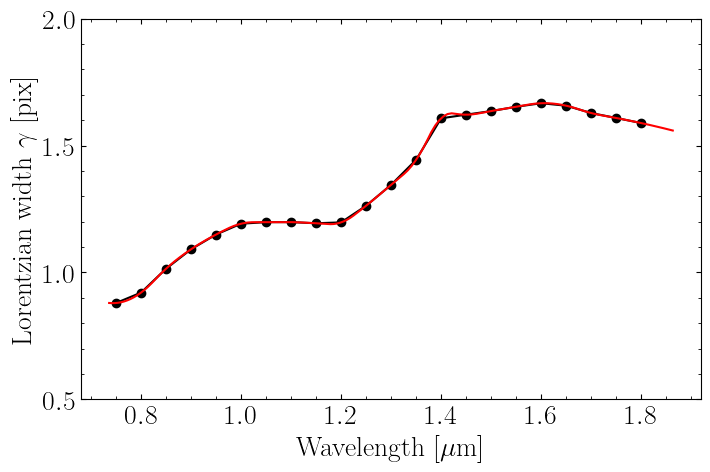

In [20]:
lorentzParameterFilename = "LSF_lorentzParameters_nPulse0022.csv"

df = pd.read_csv(lorentzParameterFilename)## .drop(index=[19,20,21]) ## .drop(index=[1,4,5,6,13])

wave  = (df['wavelength'].values * u.nanometer).to(u.angstrom)
gamma = df['gamma'].values

f = interpolate.interp1d(wave, gamma, kind='quadratic', fill_value='extrapolate')

xSize = 8
ySize = xSize / GOLDEN_RATIO

fig = plt.figure(figsize=(xSize, ySize))
ax  = fig.add_subplot(111)

ax.plot(wave.to(u.micron), gamma, 'ko-')

yMin, yMax = ax.get_ylim()

ax.plot(wavePix.to(u.micron),f(wavePix.value), 'r-')

## ax.set_ylim(yMin, yMax)

ax.set_ylim(0.5, 2.0)

ax.set_xlabel(r'Wavelength [$\mu$m]')

ax.set_ylabel(r'Lorentzian width $\gamma$ [pix]');

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

In [21]:
## Get the relevant data again
noisySpec     = hduList['SCI', 1].data.T
varImage      = hduList['ERR', 1].data.T ** 2
noiseFreeSpec = hduList['TRUE', 1].data.T
tExp          = float(hduList['SCI', 1].header['exptime']) * u.s

nK, nM = noisySpec.shape
    
y_c, x_c = (nK // 2), int(hduList['WAVEPIX', 1].header['W_REFPIX'])

xxMin, xxMax = x_c, x_c + hduList['WAVEPIX', 1].data['wavelength'].size

Another thing what we have to worry about, other than the weighting along the cross-dispersion axis and the width of the Lorentz function along the dispersion axis, is the zero point $x_0$ of the Lorentz function! We can find this by applying a centroiding algorithm using the Lorentz function as the model and setting $x_0$ as one of the parameters to solve.

This is a whole discussion in itself so we're not going to do that here. We're going to use the value written in the header, which is `SHIFT_X`:

In [22]:
## We call the value SHIFT_X in the header but we assign it as shiftY because now the image is transposed.
shiftY = hduList['SCI', 1].header['shift_x'] * u.arcsecond 

shiftY

<Quantity 0.033 arcsec>

In [23]:
shiftY / ROMAN_PIXEL_SCALE

<Quantity 0.3 pix>

We are now ready to extract a 1d spectrum from the 2d spectral image using optimum spectral extraction.

In [24]:
## Because we believe we now can properly weight the pixels, we set the extraction length
## to be very long, i.e. all pixels along the cross-dispersion axis in the postage stamp
dK = np.inf

## Again we re-calculate
yyMin = max(y_c-dK, 0)    ## Inclusive
yyMax = min(y_c+dK+1, nK) ## EXCLUSIVE. So add an additional 1 pixel

print(dK, y_c, yyMin, yyMax)

## Also, we'll set up an array of pixel coordinates centered on y_c so we can quickly
## calculate the weights from the Lorentzian model
pixCoords = np.arange(nK, dtype=float) - y_c

print(pixCoords)

inf 25 0 51
[-25. -24. -23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12.
 -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.
   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.
  17.  18.  19.  20.  21.  22.  23.  24.  25.]


(51,)
100 1.0400522364005311 micron 1.198073604343913
0.033 arcsec 0.3 pix


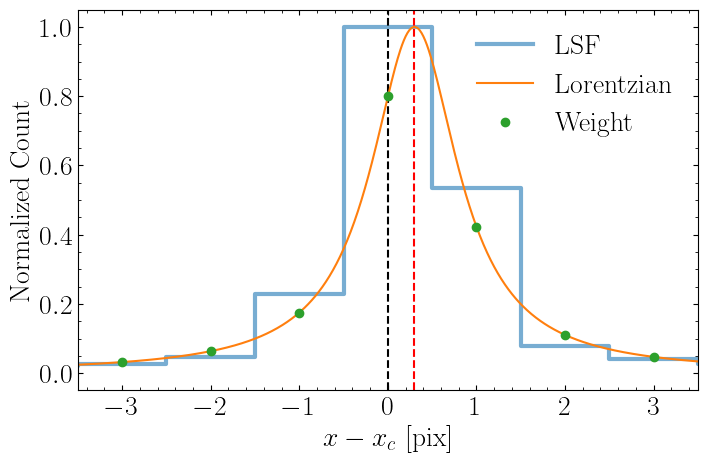

In [25]:
waveSlice = waveSlices[2]

wavelength = wavePix[waveSlice]

x_c = int(hduList['WAVEPIX', 1].header['W_REFPIX'])

xSlice = waveSlice + x_c

lsf = (noiseFreeSpec[:,xSlice])

print(lsf.shape)

gamma_test = f(wavelength.value)
shiftY_pix = shiftY / ROMAN_PIXEL_SCALE

print(waveSlice, wavelength.to(u.micron), gamma_test)

print(shiftY, shiftY_pix)

model = modeling.models.Lorentz1D(x_0=shiftY_pix.value, amplitude=1.0, fwhm=gamma_test)

xSize = 8
ySize = xSize / GOLDEN_RATIO

fig, ax = plt.subplots(figsize=(xSize, ySize))

smooth_pixCoords = np.arange(0, nK, 0.01, dtype=float) - y_c

ax.step(pixCoords, lsf / np.nanmax(lsf), where='mid', linewidth=3, label='LSF', alpha=0.6)

ax.axvline(0, color='k', linestyle='--')
ax.axvline(shiftY_pix.value, color='r', linestyle='--')

ax.plot(smooth_pixCoords, model(smooth_pixCoords), '-', label='Lorentzian')
ax.plot(pixCoords, model(pixCoords), 'o', label='Weight')

ax.set_xlim(-3.5, +3.5)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

ax.set_xlabel(r'$x - x_c$ [pix]')
ax.set_ylabel(r'Normalized Count')

ax.legend(frameon=False)

We're now going to optimally extract the 1d spectrum. Here's what we're going to do:
\begin{equation}
\begin{split}
s_{{\rm opt}, l}        &= \frac{\sum_i\frac{w_{il} f_{il}}{\sigma^2_{il}}}{\sum_i \frac{w^2_{il}}{\sigma^2_{il}}}, \\
\sigma^2_{{\rm opt}, l} &= \frac{\sum_i w_{il}}{\sum_i \frac{w^2_{il}}{\sigma^2_{il}}}.
\end{split}
\end{equation}

In [26]:
## Here's the main event. We're going to do the weighting wavelength-by-wavelength. For a given wavelength we'll
## set up a Lorentzian 1D model using astropy with the proper width and zero point.

## First we create an array to store the values of the Lorentzian HWHM as a function of the wavelength, and
## the weight array itself.
gammaInterp = np.zeros(wavePix.size)
weights     = np.zeros((wavePix.size, nK))

## We also declare an empty array to store the extracted 1d spectrum and the uncertainties
spec1d_opt_noisy  = np.empty(wavePix.size)
spec1d_opt_stdDev = np.empty(wavePix.size)

for l in range(wavePix.size):
    gammaInterp[l] = f(wavePix[l].value)

    model = modeling.models.Lorentz1D(x_0=(shiftY / ROMAN_PIXEL_SCALE).value, amplitude=1.0, fwhm=gammaInterp[l])

    weights[l] = model(pixCoords)

    weights[l] = weights[l] / weights[l, yyMin:yyMax].sum()
    
    ## This is the optimally-extracted uncalibrated 1d spectrum
    spec1d_opt_noisy[l]  = np.sum(weights[l, yyMin:yyMax] * noisySpec[yyMin:yyMax,l+xxMin] / varImage[yyMin:yyMax,l+xxMin]) / np.sum(weights[l, yyMin:yyMax]**2 / varImage[yyMin:yyMax,l+xxMin])
    spec1d_opt_stdDev[l] = np.sqrt(np.sum(weights[l, yyMin:yyMax]) / np.sum(weights[l, yyMin:yyMax]**2 / varImage[yyMin:yyMax,l+xxMin]))

    ## And this is the corresponding calibrated spectrum
    spec1d_opt_noisy[l]  = (spec1d_opt_noisy[l] / tExp / effArea[l] / specSamp[l]).value
    spec1d_opt_stdDev[l] = (spec1d_opt_stdDev[l] / tExp / effArea[l] / specSamp[l]).value

spec1d_opt_noisy *= syn.units.PHOTLAM
spec1d_opt_stdDev *= syn.units.PHOTLAM

fluxLoss_opt = (spec1d_opt_noisy - sn_true1dSpec) / sn_true1dSpec

snr_opt = spec1d_opt_noisy / spec1d_opt_stdDev

OPTIMAL EXTRACTION MEDIAN FLUX LOSS = 0.017073742372830738 MEDIAN SNR = 9.874532944707038


<Figure size 800x988.854 with 0 Axes>

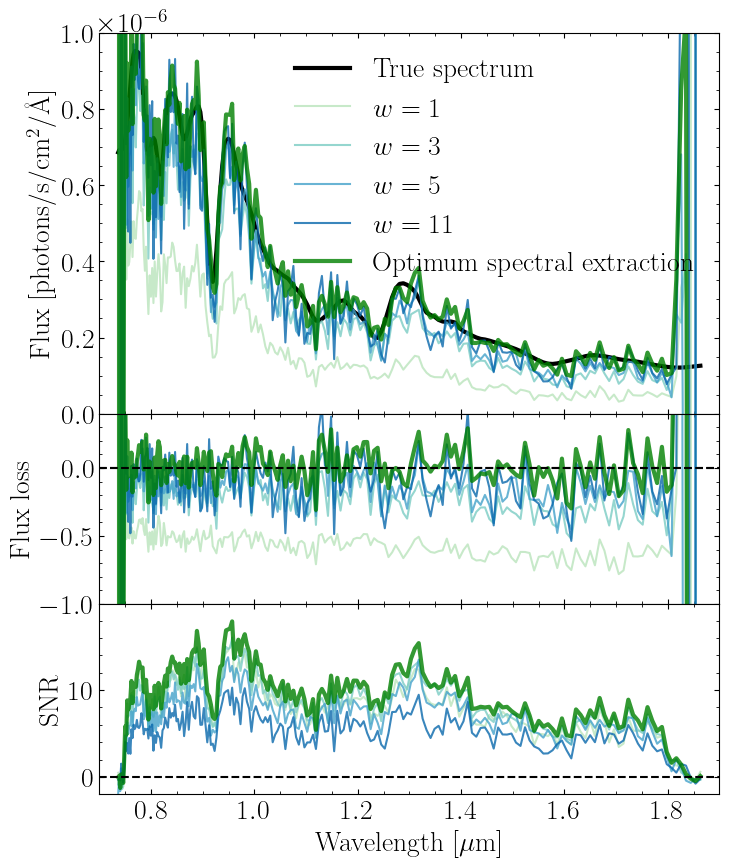

In [27]:
nRows = 3
nCols = 1

xSize = 8
ySize = 2 * xSize / GOLDEN_RATIO

xMin, xMax, dX, dMX = 0.7000, 1.9000, 0.2000, 0.0500

yMin, yMax = 0.0, 1.e-6

opacity = 0.8

fig = plt.figure(figsize=(xSize, ySize))

fig, axes = plt.subplots(nRows, nCols, sharex=True, sharey=False, figsize=(xSize, ySize), height_ratios=[1.0, 0.5, 0.5])

plt.subplots_adjust(hspace=0.0)

axes[0].plot(wavePix.to(u.micron), sn_true1dSpec, 'k-', label='True spectrum', linewidth=3)

axes[1].axhline(color='k', linestyle='--')

for k, (dK, color) in enumerate(zip(dKs, colors)):
    label = '$w = '+'{0:d}'.format(2 * dK + 1)+'$'
    
    spec1dNoisy  = spec1d_uncalib[k] * u.adu / u.pix
    spec1dStdDev = spec1d_uncalib_stdDev[k] * u.adu / u.pix

    ## Here the spectrum is divided by the spectral sampling, effective area, and the exposure time
    spec1d_cal_noisy = (spec1dNoisy / exposureTimeSp / effArea / specSamp) / (1.0 * u.adu / u.ph)
    spec1d_cal_std   = (spec1dStdDev /  exposureTimeSp / effArea / specSamp) / (1.0 * u.adu / u.ph)

    axes[0].plot(wavePix.to(u.micron), spec1d_cal_noisy, '-', color=color, label=label, alpha=opacity)

    fluxLoss = (spec1d_cal_noisy - sn_true1dSpec) / sn_true1dSpec

    axes[1].plot(wavePix.to(u.micron), fluxLoss, '-', color=color, label=label, alpha=opacity)

    snr_cal = spec1d_cal_noisy / spec1d_cal_std

    axes[2].plot(wavePix.to(u.micron), snr_cal, '-', color=color, label=label, alpha=opacity)

opt_color ='green'

print("OPTIMAL EXTRACTION MEDIAN FLUX LOSS =", np.nanmedian(fluxLoss_opt), "MEDIAN SNR =", np.nanmedian(snr_opt))

axes[0].plot(wavePix.to(u.micron), spec1d_opt_noisy, '-', color=opt_color, label='Optimum spectral extraction', linewidth=3, alpha=opacity)
axes[1].plot(wavePix.to(u.micron), fluxLoss_opt, '-', color=opt_color, linewidth=3, alpha=opacity)
axes[2].plot(wavePix.to(u.micron), snr_opt, '-', color=opt_color, linewidth=3, alpha=opacity)

axes[0].set_xlim(xMin, xMax)
axes[0].set_ylim(0.0, yMax)
axes[0].xaxis.set_major_locator(ticker.AutoLocator())
axes[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
axes[0].yaxis.set_major_locator(ticker.AutoLocator())
axes[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())

axes[0].legend(frameon=False);

axes[1].axhline(linestyle='--', color='k')

axes[1].yaxis.set_major_locator(ticker.AutoLocator())
axes[1].yaxis.set_minor_locator(ticker.AutoMinorLocator())

axes[1].set_ylim(-1.0, +0.4)

axes[0].set_ylabel(r'Flux [photons/s/cm$^2$/\AA]')

axes[1].set_ylabel(r'Flux loss')

axes[2].axhline(linestyle='--', color='k')

axes[2].set_xlabel(r'Wavelength [$\mu$m]')

axes[2].set_ylim(-2.0, +19.9)
axes[2].yaxis.set_major_locator(ticker.AutoLocator())
axes[2].yaxis.set_minor_locator(ticker.AutoMinorLocator())

axes[2].set_ylabel(r'SNR');

As we can see, not only that the SNR is better, but also the flux loss (i.e. bias) minimized! Don't you just love it when a plan comes together?

However, before we leave, let's discuss a few caveats here. First, optimum spectral extraction depends on accurate calibration tables, namely the model for the weighting scheme, which might not be easy to come by and/or require some calibration data. Secondly, it works best on point sources, as the optimum extraction's weighting scheme is based on that assumption.

As an exercise, feel free to extract 1d spectra from the bag of spectra of your favorite object.

Something to think about: In the bag of spectra, the prism 2d spectral image contains more than one observation for a given object. How do we co-add these individual observations to obtain co-added spectra?